<a href="https://colab.research.google.com/github/samantha-isaac/Emotion-Detection-in-Images-and-Music-Pairing-Through-AI/blob/main/CNN_FTunes_Landscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNs Grid Search for the Landscape Dataset

Samantha Isaac

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, Input, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
import itertools

In [ ]:
# This is to mount Drive to this project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Connect to My Drive
%cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
# Path to the folder for the Landscape dataset
dataset_folder = '/content/drive/MyDrive/Dissertation/Code/Data_Landscapes'

In [ ]:
# This function helps load the images and assigns as the labels the name of the correspodning folder
# References used for the function with os: https://docs.python.org/3/library/os.html
def load_images_and_labels(folder_path):
    images = []
    labels = []
    sub_folders = os.listdir(folder_path)

    for sub_folder in sub_folders:
        label = sub_folder # In here is where the name of the sub folders is taken as the label
        image_files = os.listdir(os.path.join(folder_path, sub_folder))

        for image_file in image_files:
            image_path = os.path.join(folder_path, sub_folder, image_file)

            image = cv2.imread(image_path, cv2.IMREAD_COLOR) # It reads the images in BGR
            if image is not None:
                image = cv2.resize(image, (96, 96)) # Redimention the images
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # This is to convert from BGR to RGB
                # Reference for this: https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html
                images.append(image)
                labels.append(label)

    return np.array(images), labels

In [ ]:
# To load images and labels
images, labels = load_images_and_labels(dataset_folder)

In [ ]:
# To create the training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.8, random_state=42, stratify=labels)

In [ ]:
# To crerate a dictionary that assigns a numeric value to each label
label_map = {label: idx for idx, label in enumerate(set(train_labels))}
# For both training and testing dataset, it replace the label with the correspodning numeric value stablich in the line above
train_labels_numeric = [label_map[label] for label in train_labels]
test_labels_numeric = [label_map[label] for label in test_labels]

In [ ]:
# Convert labels to one-hot encoding. Reference from: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
num_classes = len(label_map)
train_labels_encoded = to_categorical(train_labels_numeric, num_classes=num_classes)
test_labels_encoded = to_categorical(test_labels_numeric, num_classes=num_classes)

In [ ]:
# To normalize and to convert in arrays of NumPy. Reference from: https://numpy.org/doc/stable/reference/generated/numpy.array.html
train_images = train_images / 255.0
test_images = test_images / 255.0

# To verify that the asignation of the values was made correctly
print("Mapping of labels to numeric values:")
print(label_map)

Mapping of labels to numeric values:
{'sadness': 0, 'joy': 1, 'melancholy': 2, 'liveliness': 3}



Showing images of the class: sadness

Showing images of the class: joy

Showing images of the class: melancholy

Showing images of the class: liveliness


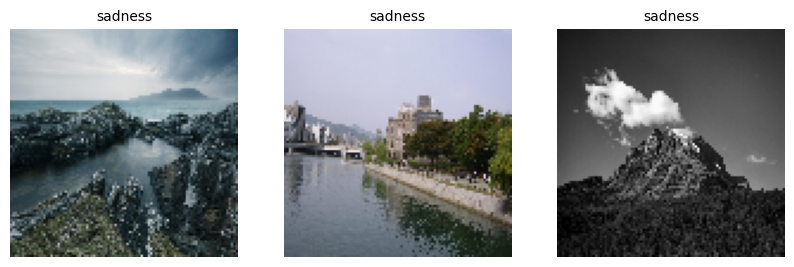

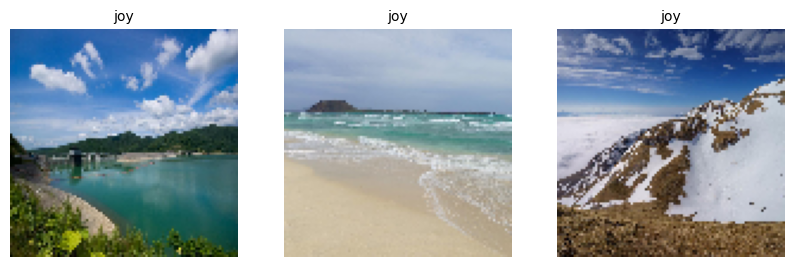

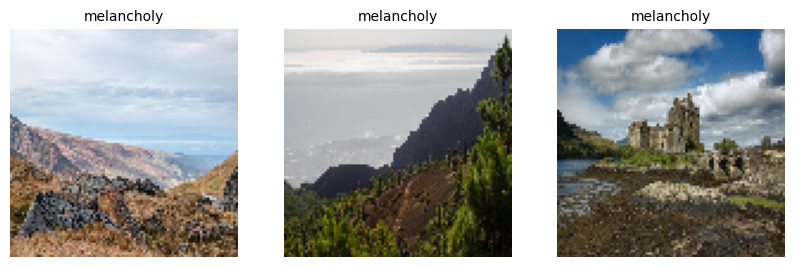

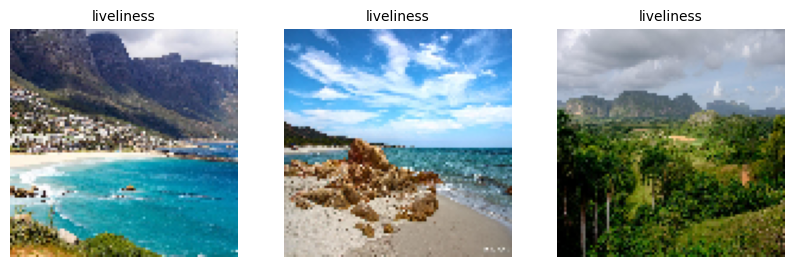

In [ ]:
# This was an extra added to improve the generalisability of the model, generating new modified versions of the images
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(train_images)

# This is to show a few images to visually verify the images and the labels
def show_images_per_class(images, labels, clase, num_imagenes = 3):
    print(f"\nShowing images of the class: {clase}") # This line was added to explicitatly indicate which images are being shown
    fig, axes = plt.subplots(1, num_imagenes, figsize = (10, 3)) # Reference from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
    # This is to create a list of the specific images
    imagenes_clase = [img for img, lbl in zip(images, labels) if lbl == clase]

# This is to iterate and take only the specific number of images, which is 3
    for i in range(num_imagenes):
        if i < len(imagenes_clase):
            axes[i].imshow(imagenes_clase[i])  # To show the images in a RGB format
            axes[i].axis('off')
            # To add title with the corresponding label of each image
            axes[i].set_title(clase, fontsize=10)
        else:
            axes[i].axis('off')

# To show some images with the corresponding labels
for label in set(train_labels):
    show_images_per_class(train_images, train_labels, label)
plt.show()

In [ ]:
# Stablish the structure of the CNN model. Used a reference for most of the structure of the models
# the project of: https://medium.com/@skillcate/emotion-detection-model-using-cnn-a-complete-guide-831db1421fael
def build_model(activation='relu', optimizer_name='adam', dropout_rate=0.5, l2_rate=0.001):
    input = Input(shape = (96, 96, 3)) # Input for images in the shape of 96x96 with 3 canales

    conv1 = Conv2D(64, (3, 3), padding = 'same', kernel_regularizer = l2(l2_rate))(input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation)(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    pool1 = Dropout(dropout_rate)(pool1)

    conv2 = Conv2D(128, (3, 3), padding = 'same', kernel_regularizer = l2(l2_rate))(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation)(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    pool2 = Dropout(dropout_rate)(pool2)

    conv3 = Conv2D(256, (3, 3), padding = 'same', kernel_regularizer = l2(l2_rate))(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation)(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    pool3 = Dropout(dropout_rate)(pool3)

    conv4 = Conv2D(512, (3, 3), padding = 'same', kernel_regularizer = l2(l2_rate))(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)

    gap = tf.keras.layers.GlobalAveragePooling2D()(pool4)

    dense_1 = Dense(256, activation = activation)(gap)
    drop_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(num_classes, activation = "softmax")(drop_1)
# To compile the model. Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
    model = Model(inputs = input, outputs = output)

    if optimizer_name == 'adam':
        optimizer_instance = Adam(learning_rate = 1e-3)
    elif optimizer_name == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate = 1e-4)

    model.compile(optimizer = optimizer_instance, loss = "categorical_crossentropy", metrics = ['accuracy'])

    return model

In [ ]:
# Here I stablished the different values of the hyperparameters for the grid search
activation_functions = ['relu', 'leaky_relu']
optimizers = ['adam', 'rmsprop']
dropout_rates = [0.4, 0.5]
l2_rates = [0.001, 0.0001]

In [ ]:
# This is for stablishing a combinations of hyperparameters. Reference: https://docs.python.org/3/library/itertools.html
hyperparameter_combinations = list(itertools.product(activation_functions, optimizers, dropout_rates, l2_rates))

In [ ]:
# To normalize and to convert in arrays of NumPy. Reference from: https://numpy.org/doc/stable/reference/generated/numpy.array.html
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0

print(f"train_images shape: {train_images.shape}")
print(f"test_images shape: {test_images.shape}")

train_images shape: (295, 96, 96, 3)
test_images shape: (1183, 96, 96, 3)


In [ ]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
# This is to initialize variables to save the best combination
best_accuracy = 0
best_combination = None
best_model = None

In [ ]:
# This code genereates the grid search for the hyperparameters search with all the combinations
for activation, optimizer_name, dropout_rate, l2_rate in hyperparameter_combinations:
  # I print the values used in the corresponding iterations
    print(f"Testing with activation: {activation}, optimizer: {optimizer_name}, dropout_rate: {dropout_rate}, l2_rate: {l2_rate}")

    # In here I build and train the model
    model = build_model(activation = activation, optimizer_name = optimizer_name, dropout_rate = dropout_rate, l2_rate = l2_rate)

    # To train the model, and I specify the parameters to use. Reference: https://stackoverflow.com/questions/37973005/what-do-model-predict-and-model-fit-do
    history = model.fit(train_images, train_labels_encoded,
                        validation_data = (test_images, test_labels_encoded),
                        epochs = 5,
                        batch_size = 64,
                        verbose = 1)

    # This is to extract the val_Accuracy to keep a record of the performance of the model
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
    best_val_accuracy = max(history.history['val_accuracy'])

    # This is a simple way to save the best model and parameters
    if best_val_accuracy > best_accuracy:
        best_accuracy = best_val_accuracy
        best_combination = (activation, optimizer_name, dropout_rate, l2_rate)
        best_model = model

print(f"Best accuracy: {best_accuracy} with parameters: {best_combination}")

Testing with activation: relu, optimizer: adam, dropout_rate: 0.4, l2_rate: 0.001
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 13s/step - accuracy: 0.2865 - loss: 3.1820 - val_accuracy: 0.2113 - val_loss: 2.0067
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 59s 13s/step - accuracy: 0.3484 - loss: 2.2822 - val_accuracy: 0.2409 - val_loss: 2.0355
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 13s/step - accuracy: 0.3940 - loss: 1.9386 - val_accuracy: 0.2113 - val_loss: 2.0528
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 13s/step - accuracy: 0.4539 - loss: 1.8701 - val_accuracy: 0.2409 - val_loss: 2.0675
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 13s/step - accuracy: 0.4731 - loss: 1.8453 - val_accuracy: 0.2409 - val_loss: 2.0938
Testing with activation: relu, optimizer: adam, dropout_rate: 0.4, l2_rate: 0.0001
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 13s/step - accuracy: 0.2921 - loss: 2.4510 - val_accuracy: 0.2409 - val_loss: 1.4582
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 94s 17s/step - accuracy: 0.3688 - loss: 1.6207 - val_acc